In [1]:
# Import components
import datetime as dt
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

plt.rcParams["font.family"] = "Hiragino Maru Gothic Pro"
plt.style.use("ggplot")  # グラフのスタイル
plt.rcParams["figure.figsize"] = [12, 9]  # グラフサイズ設定

df = pd.read_csv("./datasets/fixed_battery_log_2.csv")
df["date"] = pd.to_datetime(df["date"])
users = df["User"].unique()
first = 1
last = 31


def Frequency_Distribution(data, bins, class_width=None):
    data = np.asarray(data)

    #     bins = np.arange(0, 110, 10)
    hist = np.histogram(data, bins)[0]
    cumsum = hist.cumsum()

    return pd.DataFrame(
        {
            "階級値": (bins[1:] + bins[:-1]) / 2,
            "度数": hist,
            "累積度数": cumsum,
            "相対度数": hist / cumsum[-1],
            "累積相対度数": cumsum / cumsum[-1],
        },
        index=pd.Index(
            [f"{bins[i]}以上{bins[i+1]}未満" for i in range(hist.size)], name="階級"
        ),
    )

# ターゲットのテンプレート作成

In [75]:
target = users[0]
t_T = pd.DataFrame(
    df.loc[
        (df["User"] == target)
        & (df["state"] == "ON")
        & (df["date"] > dt.datetime(2021, 12, first))
        & (df["date"] < dt.datetime(2021, 12, last))
    ]["battery"].copy()
)
t_T = t_T.set_index(np.arange(0, len(t_T)))
t_T = Frequency_Distribution(t_T, np.arange(0, 105, 5))

# ターゲットのクエリ作成

In [86]:
first_date_cand = pd.date_range("2022-01-01", "2022-02-01")
t_Q_list = []
for i in range(30):
    first_date = first_date_cand[np.random.randint(0, len(first_date_cand), 1)]
    last_date = first_date + dt.timedelta(days=30)
    t_Q = pd.DataFrame(
        df.loc[
            (df["User"] == target)
            & (df["state"] == "ON")
            & (df["date"] > first_date[0])
            & (df["date"] < last_date[0])
        ]["battery"].copy()
    )
    t_Q = t_Q.set_index(np.arange(0, len(t_Q)))
    t_Q = Frequency_Distribution(t_Q, np.arange(0, 105, 5))
    t_Q_list.append(t_Q)

# 他人のクエリ作成

In [126]:
first_date_cand = pd.date_range("2022-01-01", "2022-02-01")
i_Q_list = []
target = users[0]
imposters = users.copy()
imposters = imposters[~(imposters == target)]

for i in range(30):
    first_date = first_date_cand[np.random.randint(0, len(first_date_cand), 1)]
    last_date = first_date + dt.timedelta(days=30)
    i_Q = pd.DataFrame(
        df.loc[
            (df["User"] == np.random.choice(imposters))
            & (df["state"] == "ON")
            & (df["date"] > first_date[0])
            & (df["date"] < last_date[0])
        ]["battery"].copy()
    )
    i_Q = i_Q.set_index(np.arange(0, len(i_Q)))
    i_Q = Frequency_Distribution(i_Q, np.arange(0, 105, 5))
    i_Q_list.append(i_Q)

# 本人類似度チェック(ユークリッド距離使用)

<AxesSubplot:xlabel='階級'>

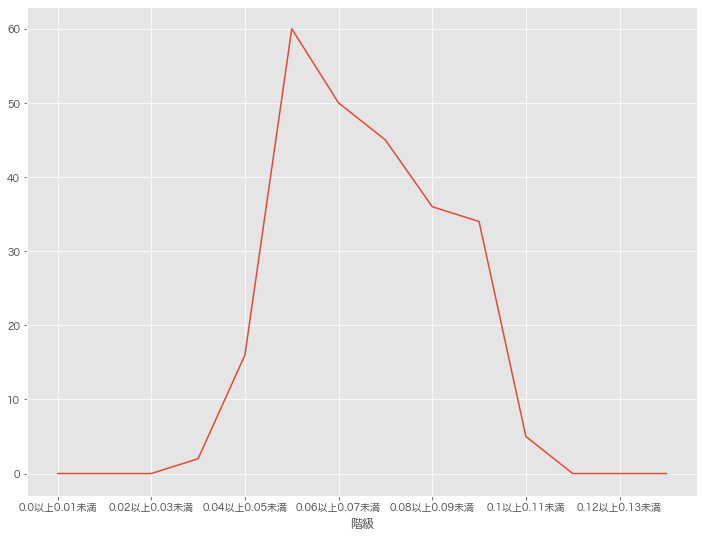

In [118]:
diff_list_gen = []
for h in range(len(users)):
    target = users[h]

    t_T = pd.DataFrame(
        df.loc[
            (df["User"] == target)
            & (df["state"] == "ON")
            & (df["date"] > dt.datetime(2021, 12, first))
            & (df["date"] < dt.datetime(2021, 12, last))
        ]["battery"].copy()
    )

    t_T = t_T.set_index(np.arange(0, len(t_T)))
    t_T = Frequency_Distribution(t_T, np.arange(0, 105, 5))
    first_date_cand = pd.date_range("2022-01-01", "2022-02-01")
    t_Q_list = []

    for i in range(0, 31):
        first_date = first_date_cand[np.random.randint(0, len(first_date_cand), 1)]
        last_date = first_date + dt.timedelta(days=30)
        t_Q = pd.DataFrame(
            df.loc[
                (df["User"] == target)
                & (df["state"] == "ON")
                & (df["date"] > first_date[0])
                & (df["date"] < last_date[0])
            ]["battery"].copy()
        )
        t_Q = t_Q.set_index(np.arange(0, len(t_Q)))
        t_Q = Frequency_Distribution(t_Q, np.arange(0, 105, 5))
        t_Q_list.append(t_Q)

    for j in range(len(t_Q_list)):
        diff = 0
        for g in range(len(t_T)):
            diff += (t_T["度数"][g] - t_Q_list[j]["度数"][g]) ** 2
        diff = 1 / (math.sqrt(diff) + 1)
        diff_list_gen.append(diff)

sim_FD_gen = Frequency_Distribution(diff_list_gen, np.arange(0, 0.15, 0.01))
sim_FD_gen["度数"].plot()

0.07071414724657364
0.016450569185321107


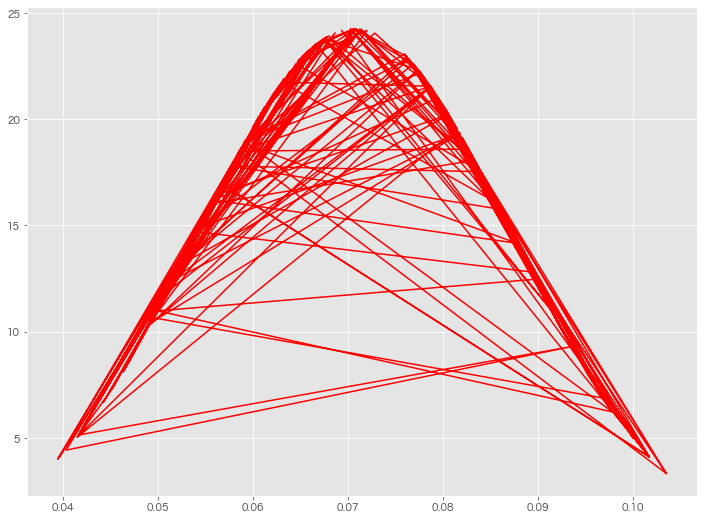

In [40]:
from scipy.stats import norm

X = diff_list_gen
print(np.mean(X))
print(np.std(X))
Y = norm.pdf(X, np.mean(X), np.std(X))
plt.plot(X, Y, color="r")
plt.show()

# 他人類似度調査(ユークリッド距離)

<AxesSubplot:xlabel='階級'>

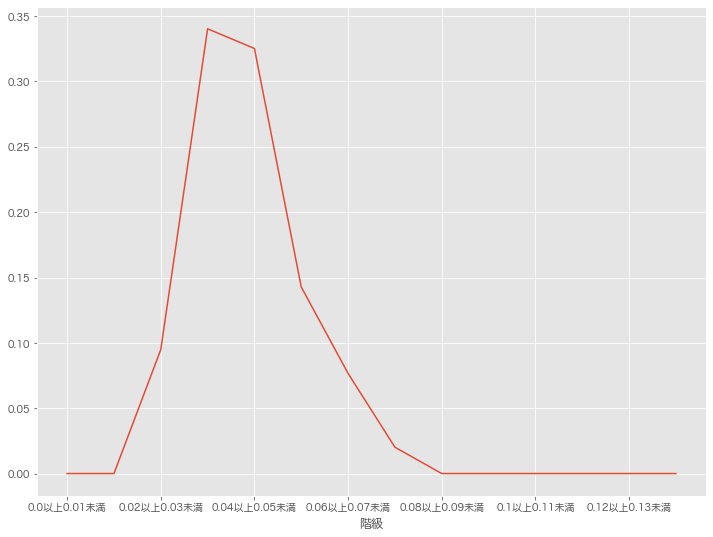

In [64]:
diff_list_im = []
for h in range(len(users)):
    target = users[h]

    t_T = pd.DataFrame(
        df.loc[
            (df["User"] == target)
            & (df["state"] == "ON")
            & (df["date"] > dt.datetime(2021, 12, first))
            & (df["date"] < dt.datetime(2021, 12, last))
        ]["battery"].copy()
    )

    t_T = t_T.set_index(np.arange(0, len(t_T)))
    t_T = Frequency_Distribution(t_T, np.arange(0, 105, 5))

    first_date_cand = pd.date_range("2022-01-01", "2022-02-01")
    i_Q_list = []
    target = users[h]
    imposters = users.copy()
    imposters = imposters[~(imposters == target)]

    for i in range(30):
        first_date = first_date_cand[np.random.randint(0, len(first_date_cand), 1)]
        last_date = first_date + dt.timedelta(days=30)
        i_Q = pd.DataFrame(
            df.loc[
                (df["User"] == np.random.choice(imposters))
                & (df["state"] == "ON")
                & (df["date"] > first_date[0])
                & (df["date"] < last_date[0])
            ]["battery"].copy()
        )
        i_Q = i_Q.set_index(np.arange(0, len(i_Q)))
        i_Q = Frequency_Distribution(i_Q, np.arange(0, 105, 5))
        i_Q_list.append(i_Q)

        for j in range(len(i_Q_list)):
            diff = 0
            for g in range(len(t_T)):
                diff += (t_T["度数"][g] - i_Q_list[j]["度数"][g]) ** 2
            diff = 1 / (math.sqrt(diff) + 1)
            diff_list_im.append(diff)

sim_FD_im = Frequency_Distribution(diff_list_im, np.arange(0, 0.15, 0.01))
sim_FD_im["相対度数"].plot()

In [69]:
# # from scipy.stats import norm

# # X_1 = diff_list_gen
# # print(np.mean(X_1))
# # print(np.std(X_1))
# # Y_1 = norm.pdf(X_1, np.mean(X_1), np.std(X_1))

# # plt.plot(X_1, Y_1, color="r")

# import scipy

# # X_2 = diff_list_im
# # print(np.mean(X_2))
# # print(np.std(X_2))
# # Y_2 = norm.pdf(X_2, np.mean(X_2), np.std(X_2))
# # plt.plot(X_2, Y_2, color="b")
# # plt.show()
# from scipy.stats import norm, zscore

# X_1 = scipydiff_list_gen
# print(np.mean(X_1))
# print(np.std(X_1))
# Y_1 = norm.pdf(X_1, 0, 1)

# plt.plot(X_1, Y_1, color="r")

# X_2 = diff_list_im
# print(np.mean(X_2))
# print(np.std(X_2))
# Y_2 = norm.pdf(X_2, 0, 1)
# plt.plot(X_2, Y_2, color="b")
# plt.show()

<AxesSubplot:xlabel='階級'>

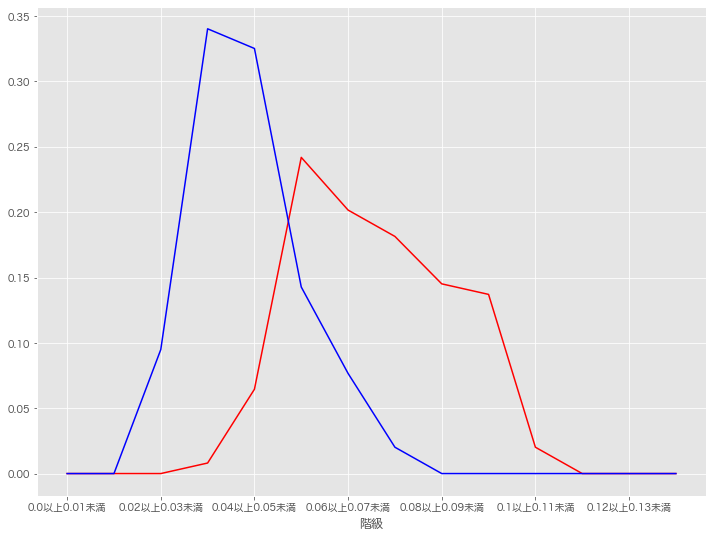

In [120]:
sim_FD_gen["相対度数"].plot(c="r")
sim_FD_im["相対度数"].plot(c="b")

In [17]:
sim_FD_gen

,階級値,度数,累積度数,相対度数,累積相対度数
階級,,,,,
0.0以上0.01未満,0.005,0,0,0.000000,0.000000
0.01以上0.02未満,0.015,0,0,0.000000,0.000000
0.02以上0.03未満,0.025,0,0,0.000000,0.000000
0.03以上0.04未満,0.035,3,3,0.012097,0.012097
0.04以上0.05未満,0.045,20,23,0.080645,0.092742
0.05以上0.06未満,0.055,60,83,0.241935,0.334677
0.06以上0.07未満,0.065,43,126,0.173387,0.508065
0.07以上0.08未満,0.075,40,166,0.161290,0.669355
0.08以上0.09未満,0.085,40,206,0.161290,0.830645


In [21]:
sim_FD_im

,階級値,度数,累積度数,相対度数,累積相対度数
階級,,,,,
0.0以上0.01未満,0.005,0,0,0.000000,0.000000
0.01以上0.02未満,0.015,0,0,0.000000,0.000000
0.02以上0.03未満,0.025,186,186,0.050000,0.050000
0.03以上0.04未満,0.035,1309,1495,0.351882,0.401882
0.04以上0.05未満,0.045,1141,2636,0.306720,0.708602
0.05以上0.06未満,0.055,630,3266,0.169355,0.877957
0.06以上0.07未満,0.065,270,3536,0.072581,0.950538
0.07以上0.08未満,0.075,184,3720,0.049462,1.000000
0.08以上0.09未満,0.085,0,3720,0.000000,1.000000


In [22]:
sim_FD_gen["相対度数"] == sim_FD_im["相対度数"]

階級
0.0以上0.01未満      True
0.01以上0.02未満     True
0.02以上0.03未満    False
0.03以上0.04未満    False
0.04以上0.05未満    False
0.05以上0.06未満    False
0.06以上0.07未満    False
0.07以上0.08未満    False
0.08以上0.09未満    False
0.09以上0.1未満     False
0.1以上0.11未満     False
0.11以上0.12未満     True
0.12以上0.13未満     True
0.13以上0.14未満     True
Name: 相対度数, dtype: bool

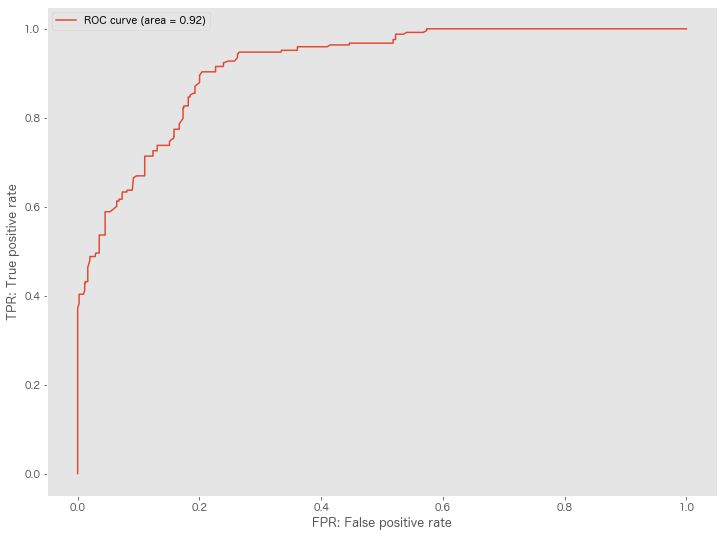

In [104]:
from sklearn import metrics

grand_truth = np.concatenate((np.ones(len(diff_list_gen)), np.zeros(len(diff_list_im))))
score = np.concatenate((diff_list_gen, diff_list_im))
fpr, tpr, threshold = metrics.roc_curve(grand_truth, score)
auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label="ROC curve (area = %.2f)" % auc)
plt.legend()
plt.xlabel("FPR: False positive rate")
plt.ylabel("TPR: True positive rate")
plt.grid()
plt.show()

0.17446236559139786


Text(0.5, 0, 'Threshold')

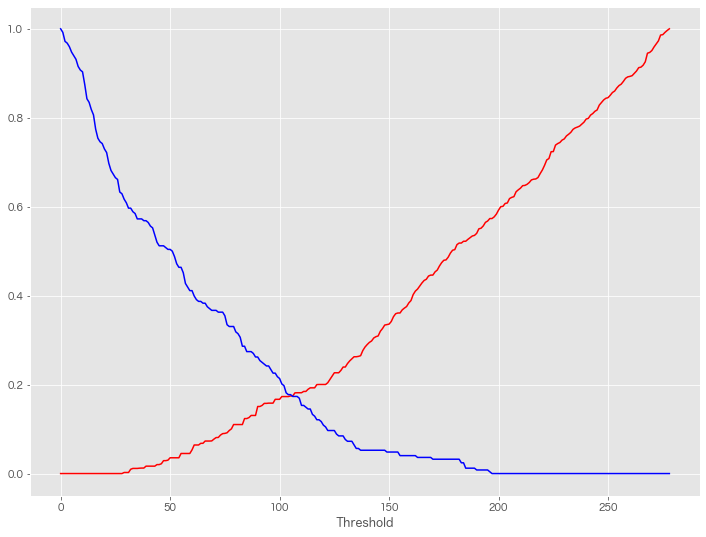

In [135]:
frr = 1.0 - tpr
eer = far[np.where((fpr - frr) < 0)[0][-1]]
print(eer)
plt.plot(fpr, color="red")
plt.plot(frr, color="blue")
plt.xlabel("Threshold")

0.17446236559139786


Text(0, 0.5, 'FRR')

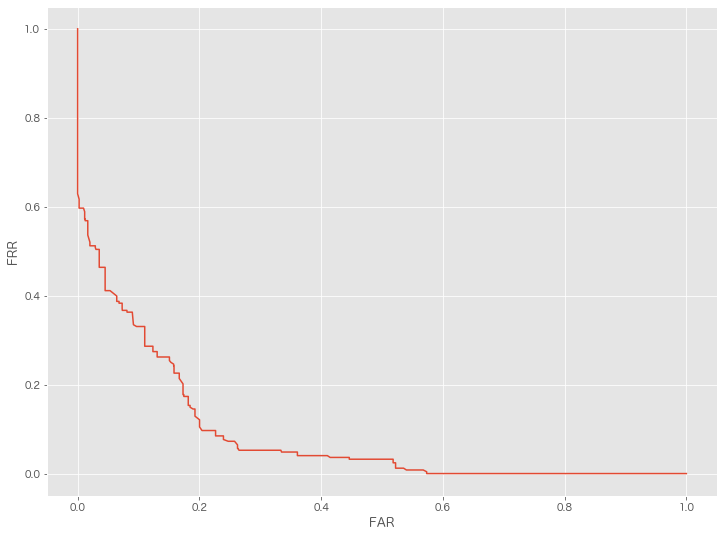

In [130]:
frr = 1.0 - tpr
eer = far[np.where((fpr - frr) < 0)[0][-1]]
plt.plot(fpr, frr)
print(eer)
plt.xlabel("FAR")
plt.ylabel("FRR")